In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [1]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops_zoomcamp/02_experiment_tracking/mlruns/2', creation_time=1716205811535, experiment_id='2', last_update_time=1716205811535, lifecycle_stage='active', name='nyc_taxi-experiment', tags={}>

In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.735793552152622

/tmp/ipykernel_7127/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_7127/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


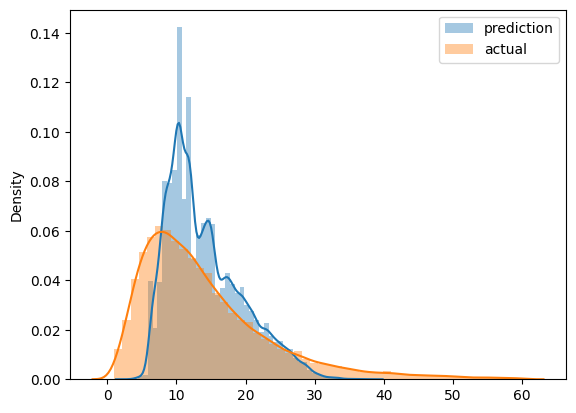

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet')

In [11]:
len(df_train), len(df_val)

(59603, 66097)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.901396794753251

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Sam")
    mlflow.sklearn.autolog()

    mlflow.log_param("training_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet")
    mlflow.log_param("valdiation_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet")


    alpha = 0.3
    # mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    # mlflow.log_metric("rmse", rmse)

2024/05/24 09:21:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Sam")
    mlflow.sklearn.autolog()

    mlflow.log_param("training_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet")
    mlflow.log_param("valdiation_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet")


    alpha = 0.3
    # mlflow.log_param("alpha", alpha)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

2024/05/24 09:24:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
import xgboost as xgb

In [19]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:58:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.07302                           
[1]	validation-rmse:8.35740                           
[2]	validation-rmse:7.80252                           
[3]	validation-rmse:7.37887                           
[4]	validation-rmse:7.05578                           
[5]	validation-rmse:6.81356                           
[6]	validation-rmse:6.62664                           
[7]	validation-rmse:6.49267                           
[8]	validation-rmse:6.38217                           
[9]	validation-rmse:6.30647                           
[10]	validation-rmse:6.24371                          
[11]	validation-rmse:6.19737                          
[12]	validation-rmse:6.15045                          
[13]	validation-rmse:6.12341                          
[14]	validation-rmse:6.09555                          
[15]	validation-rmse:6.07780                          
[16]	validation-rmse:6.06449                          
[17]	validation-rmse:6.04764                          
[18]	valid

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:59:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.26564                                                    
[1]	validation-rmse:6.17151                                                    
[2]	validation-rmse:6.13388                                                    
[3]	validation-rmse:6.11814                                                    
[4]	validation-rmse:6.09842                                                    
[5]	validation-rmse:6.09005                                                    
[6]	validation-rmse:6.08895                                                    
[7]	validation-rmse:6.07990                                                    
[8]	validation-rmse:6.08155                                                    
[9]	validation-rmse:6.07521                                                    
[10]	validation-rmse:6.07564                                                   
[11]	validation-rmse:6.06922                                                   
[12]	validation-rmse:6.06757            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:00:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99202                                                    
[1]	validation-rmse:8.22442                                                    
[2]	validation-rmse:7.64245                                                    
[3]	validation-rmse:7.20515                                                    
[4]	validation-rmse:6.88084                                                    
[5]	validation-rmse:6.64014                                                    
[6]	validation-rmse:6.46236                                                    
[7]	validation-rmse:6.32913                                                    
[8]	validation-rmse:6.23109                                                    
[9]	validation-rmse:6.15518                                                    
[10]	validation-rmse:6.09762                                                   
[11]	validation-rmse:6.05524                                                   
[12]	validation-rmse:6.01997            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:01:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.25056                                                    
[1]	validation-rmse:6.04745                                                    
[2]	validation-rmse:6.00246                                                    
[3]	validation-rmse:5.97755                                                    
[4]	validation-rmse:5.95067                                                    
[5]	validation-rmse:5.94385                                                    
[6]	validation-rmse:5.94372                                                    
[7]	validation-rmse:5.94160                                                    
[8]	validation-rmse:5.94199                                                    
[9]	validation-rmse:5.94044                                                    
[10]	validation-rmse:5.93917                                                   
[11]	validation-rmse:5.93608                                                   
[12]	validation-rmse:5.93359            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:01:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.11108                                                    
[1]	validation-rmse:6.24345                                                    
[2]	validation-rmse:5.99993                                                    
[3]	validation-rmse:5.92265                                                    
[4]	validation-rmse:5.89018                                                    
[5]	validation-rmse:5.88530                                                    
[6]	validation-rmse:5.88117                                                    
[7]	validation-rmse:5.88500                                                    
[8]	validation-rmse:5.88281                                                    
[9]	validation-rmse:5.88291                                                    
[10]	validation-rmse:5.87957                                                   
[11]	validation-rmse:5.87823                                                   
[12]	validation-rmse:5.87713            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:01:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.74432                                                    
[1]	validation-rmse:6.75156                                                    
[2]	validation-rmse:6.32907                                                    
[3]	validation-rmse:6.15215                                                    
[4]	validation-rmse:6.07257                                                    
[5]	validation-rmse:6.01775                                                    
[6]	validation-rmse:5.99091                                                    
[7]	validation-rmse:5.97951                                                    
[8]	validation-rmse:5.96402                                                    
[9]	validation-rmse:5.94976                                                    
[10]	validation-rmse:5.93499                                                   
[11]	validation-rmse:5.92386                                                   
[12]	validation-rmse:5.92141            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:02:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.61055                                                    
[1]	validation-rmse:9.26405                                                    
[2]	validation-rmse:8.94891                                                    
[3]	validation-rmse:8.66253                                                    
[4]	validation-rmse:8.40233                                                    
[5]	validation-rmse:8.16532                                                    
[6]	validation-rmse:7.95296                                                    
[7]	validation-rmse:7.75938                                                    
[8]	validation-rmse:7.58433                                                    
[9]	validation-rmse:7.42653                                                    
[10]	validation-rmse:7.28625                                                   
[11]	validation-rmse:7.15868                                                   
[12]	validation-rmse:7.04343            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:04:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.21655                                                    
[1]	validation-rmse:8.58112                                                    
[2]	validation-rmse:8.06369                                                    
[3]	validation-rmse:7.64265                                                    
[4]	validation-rmse:7.30426                                                    
[5]	validation-rmse:7.03183                                                    
[6]	validation-rmse:6.81531                                                    
[7]	validation-rmse:6.64291                                                    
[8]	validation-rmse:6.50540                                                    
[9]	validation-rmse:6.39642                                                    
[10]	validation-rmse:6.30973                                                   
[11]	validation-rmse:6.24042                                                   
[12]	validation-rmse:6.18527            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:05:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.64963                                                    
[1]	validation-rmse:9.33662                                                    
[2]	validation-rmse:9.04959                                                    
[3]	validation-rmse:8.78690                                                    
[4]	validation-rmse:8.54663                                                    
[5]	validation-rmse:8.32713                                                    
[6]	validation-rmse:8.12713                                                    
[7]	validation-rmse:7.94466                                                    
[8]	validation-rmse:7.77862                                                    
[9]	validation-rmse:7.62766                                                    
[10]	validation-rmse:7.49056                                                   
[11]	validation-rmse:7.36616                                                   
[12]	validation-rmse:7.25345            

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:08:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.56358                                                      
[1]	validation-rmse:6.68415                                                      
[2]	validation-rmse:6.36618                                                      
[3]	validation-rmse:6.24751                                                      
[4]	validation-rmse:6.19147                                                      
[5]	validation-rmse:6.17409                                                      
[6]	validation-rmse:6.15844                                                      
[7]	validation-rmse:6.15707                                                      
[8]	validation-rmse:6.15354                                                      
[9]	validation-rmse:6.15311                                                      
[10]	validation-rmse:6.15174                                                     
[11]	validation-rmse:6.15250                                                     
[12]	validation-

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:08:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.63001                                                     
[1]	validation-rmse:9.30205                                                     
[2]	validation-rmse:9.00213                                                     
[3]	validation-rmse:8.72608                                                     
[4]	validation-rmse:8.47475                                                     
[5]	validation-rmse:8.24233                                                     
[6]	validation-rmse:8.03708                                                     
[7]	validation-rmse:7.84707                                                     
[8]	validation-rmse:7.67533                                                     
[9]	validation-rmse:7.51696                                                     
[10]	validation-rmse:7.37449                                                    
[11]	validation-rmse:7.24800                                                    
[12]	validation-rmse:7.12701

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.21832                                                        
[1]	validation-rmse:8.58560                                                        
[2]	validation-rmse:8.07073                                                        
[3]	validation-rmse:7.65561                                                        
[4]	validation-rmse:7.32235                                                        
[5]	validation-rmse:7.05536                                                        
[6]	validation-rmse:6.84306                                                        
[7]	validation-rmse:6.67217                                                        
[8]	validation-rmse:6.53703                                                        
[9]	validation-rmse:6.42963                                                        
[10]	validation-rmse:6.34556                                                       
[11]	validation-rmse:6.27857                                                

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.91741                                                        
[1]	validation-rmse:8.11311                                                        
[2]	validation-rmse:7.52070                                                        
[3]	validation-rmse:7.09030                                                        
[4]	validation-rmse:6.78004                                                        
[5]	validation-rmse:6.55603                                                        
[6]	validation-rmse:6.39834                                                        
[7]	validation-rmse:6.28321                                                        
[8]	validation-rmse:6.19967                                                        
[9]	validation-rmse:6.14043                                                        
[10]	validation-rmse:6.09668                                                       
[11]	validation-rmse:6.06494                                                

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78244                                                       
[1]	validation-rmse:7.93068                                                       
[2]	validation-rmse:7.33962                                                       
[3]	validation-rmse:6.93277                                                       
[4]	validation-rmse:6.66013                                                       
[5]	validation-rmse:6.47368                                                       
[6]	validation-rmse:6.34974                                                       
[7]	validation-rmse:6.26092                                                       
[8]	validation-rmse:6.19919                                                       
[9]	validation-rmse:6.15251                                                       
[10]	validation-rmse:6.11974                                                      
[11]	validation-rmse:6.09487                                                      
[12]

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.68119                                                     
[1]	validation-rmse:7.80386                                                     
[2]	validation-rmse:7.20578                                                     
[3]	validation-rmse:6.80115                                                     
[4]	validation-rmse:6.53974                                                     
[5]	validation-rmse:6.37764                                                     
[6]	validation-rmse:6.24906                                                     
[7]	validation-rmse:6.17983                                                     
[8]	validation-rmse:6.11588                                                     
[9]	validation-rmse:6.08870                                                     
[10]	validation-rmse:6.06245                                                    
[11]	validation-rmse:6.03962                                                    
[12]	validation-rmse:6.02696

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.96964                                                     
[1]	validation-rmse:8.18907                                                     
[2]	validation-rmse:7.60039                                                     
[3]	validation-rmse:7.16131                                                     
[4]	validation-rmse:6.83803                                                     
[5]	validation-rmse:6.59614                                                     
[6]	validation-rmse:6.42196                                                     
[7]	validation-rmse:6.29089                                                     
[8]	validation-rmse:6.19472                                                     
[9]	validation-rmse:6.12254                                                     
[10]	validation-rmse:6.07020                                                    
[11]	validation-rmse:6.02801                                                    
[12]	validation-rmse:5.99685

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.05345                                                     
[1]	validation-rmse:6.33231                                                     
[2]	validation-rmse:6.14339                                                     
[3]	validation-rmse:6.08055                                                     
[4]	validation-rmse:6.06086                                                     
[5]	validation-rmse:6.05573                                                     
[6]	validation-rmse:6.04861                                                     
[7]	validation-rmse:6.04659                                                     
[8]	validation-rmse:6.03544                                                     
[9]	validation-rmse:6.03018                                                     
[10]	validation-rmse:6.02495                                                    
[11]	validation-rmse:6.02429                                                    
[12]	validation-rmse:6.01976

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.65922                                                     
[1]	validation-rmse:9.35270                                                     
[2]	validation-rmse:9.06930                                                     
[3]	validation-rmse:8.80768                                                     
[4]	validation-rmse:8.56609                                                     
[5]	validation-rmse:8.34347                                                     
[6]	validation-rmse:8.13846                                                     
[7]	validation-rmse:7.94983                                                     
[8]	validation-rmse:7.77660                                                     
[9]	validation-rmse:7.61802                                                     
[10]	validation-rmse:7.47227                                                    
[11]	validation-rmse:7.33921                                                    
[12]	validation-rmse:7.21774

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.87733                                                     
[1]	validation-rmse:6.17208                                                     
[2]	validation-rmse:6.00533                                                     
[3]	validation-rmse:5.94098                                                     
[4]	validation-rmse:5.91723                                                     
[5]	validation-rmse:5.91020                                                     
[6]	validation-rmse:5.90427                                                     
[7]	validation-rmse:5.89022                                                     
[8]	validation-rmse:5.88525                                                     
[9]	validation-rmse:5.88381                                                     
[10]	validation-rmse:5.87715                                                    
[11]	validation-rmse:5.87755                                                    
[12]	validation-rmse:5.87711

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.52951                                                     
[1]	validation-rmse:9.11705                                                     
[2]	validation-rmse:8.74781                                                     
[3]	validation-rmse:8.41924                                                     
[4]	validation-rmse:8.12671                                                     
[5]	validation-rmse:7.86808                                                     
[6]	validation-rmse:7.63915                                                     
[7]	validation-rmse:7.43520                                                     
[8]	validation-rmse:7.25624                                                     
[9]	validation-rmse:7.09720                                                     
[10]	validation-rmse:6.95841                                                    
[11]	validation-rmse:6.83550                                                    
[12]	validation-rmse:6.72851

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.47194                                                     
[1]	validation-rmse:9.01636                                                     
[2]	validation-rmse:8.61676                                                     
[3]	validation-rmse:8.26731                                                     
[4]	validation-rmse:7.96381                                                     
[5]	validation-rmse:7.69901                                                     
[6]	validation-rmse:7.47020                                                     
[7]	validation-rmse:7.27266                                                     
[8]	validation-rmse:7.09887                                                     
[9]	validation-rmse:6.95166                                                     
[10]	validation-rmse:6.82344                                                    
[11]	validation-rmse:6.71388                                                    
[12]	validation-rmse:6.61746

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48436                                                     
[1]	validation-rmse:9.03975                                                     
[2]	validation-rmse:8.64949                                                     
[3]	validation-rmse:8.30784                                                     
[4]	validation-rmse:8.00966                                                     
[5]	validation-rmse:7.74750                                                     
[6]	validation-rmse:7.52105                                                     
[7]	validation-rmse:7.32387                                                     
[8]	validation-rmse:7.15105                                                     
[9]	validation-rmse:7.00314                                                     
[10]	validation-rmse:6.87534                                                    
[11]	validation-rmse:6.76457                                                    
[12]	validation-rmse:6.66858

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.47446                                                     
[1]	validation-rmse:9.02035                                                     
[2]	validation-rmse:8.62118                                                     
[3]	validation-rmse:8.27260                                                     
[4]	validation-rmse:7.96887                                                     
[5]	validation-rmse:7.70474                                                     
[6]	validation-rmse:7.47551                                                     
[7]	validation-rmse:7.27820                                                     
[8]	validation-rmse:7.10564                                                     
[9]	validation-rmse:6.95658                                                     
[10]	validation-rmse:6.82793                                                    
[11]	validation-rmse:6.71593                                                    
[12]	validation-rmse:6.61943

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:26:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.42419                                                     
[2]	validation-rmse:6.90641                                                     
[3]	validation-rmse:6.61725                                                     
[4]	validation-rmse:6.45512                                                     
[5]	validation-rmse:6.36264                                                     
[6]	validation-rmse:6.30820                                                     
[7]	validation-rmse:6.27193                                                     
[8]	validation-rmse:6.24882                                                     
[9]	validation-rmse:6.23275                                                     
[10]	validation-rmse:6.22057                                                    
[11]	validation-rmse:6.21493                                                    
[12]	validation-rmse:6.20705                                                    
[13]	validation-rmse:6.20314

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:27:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.36025                                                     
[1]	validation-rmse:8.82709                                                     
[2]	validation-rmse:8.37703                                                     
[3]	validation-rmse:7.99857                                                     
[4]	validation-rmse:7.68103                                                     
[5]	validation-rmse:7.42156                                                     
[6]	validation-rmse:7.20676                                                     
[7]	validation-rmse:7.02612                                                     
[8]	validation-rmse:6.87646                                                     
[9]	validation-rmse:6.75290                                                     
[10]	validation-rmse:6.65102                                                    
[11]	validation-rmse:6.56732                                                    
[12]	validation-rmse:6.49734

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:28:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.55823                                                     
[1]	validation-rmse:9.16959                                                     
[2]	validation-rmse:8.81753                                                     
[3]	validation-rmse:8.50140                                                     
[4]	validation-rmse:8.21927                                                     
[5]	validation-rmse:7.96784                                                     
[6]	validation-rmse:7.74127                                                     
[7]	validation-rmse:7.54019                                                     
[8]	validation-rmse:7.36126                                                     
[9]	validation-rmse:7.20047                                                     
[10]	validation-rmse:7.05920                                                    
[11]	validation-rmse:6.93309                                                    
[12]	validation-rmse:6.82087

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:29:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.39002                                                     
[1]	validation-rmse:8.87436                                                     
[2]	validation-rmse:8.43421                                                     
[3]	validation-rmse:8.05885                                                     
[4]	validation-rmse:7.74135                                                     
[5]	validation-rmse:7.47281                                                     
[6]	validation-rmse:7.24684                                                     
[7]	validation-rmse:7.05728                                                     
[8]	validation-rmse:6.89631                                                     
[9]	validation-rmse:6.76195                                                     
[10]	validation-rmse:6.64977                                                    
[11]	validation-rmse:6.55532                                                    
[12]	validation-rmse:6.47700

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:31:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.68427                                                     
[1]	validation-rmse:9.39951                                                     
[2]	validation-rmse:9.13568                                                     
[3]	validation-rmse:8.89077                                                     
[4]	validation-rmse:8.66362                                                     
[5]	validation-rmse:8.45284                                                     
[6]	validation-rmse:8.25786                                                     
[7]	validation-rmse:8.07860                                                     
[8]	validation-rmse:7.91293                                                     
[9]	validation-rmse:7.75919                                                     
[10]	validation-rmse:7.61809                                                    
[11]	validation-rmse:7.48761                                                    
[12]	validation-rmse:7.36676

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:33:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.36180                                                     
[1]	validation-rmse:7.38677                                                     
[2]	validation-rmse:6.82220                                                     
[3]	validation-rmse:6.47858                                                     
[4]	validation-rmse:6.29060                                                     
[5]	validation-rmse:6.18521                                                     
[6]	validation-rmse:6.11006                                                     
[7]	validation-rmse:6.06949                                                     
[8]	validation-rmse:6.03565                                                     
[9]	validation-rmse:6.01167                                                     
[10]	validation-rmse:5.99909                                                    
[11]	validation-rmse:5.98861                                                    
[12]	validation-rmse:5.98218

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:34:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.25435                                                     
[1]	validation-rmse:8.64754                                                     
[2]	validation-rmse:8.15501                                                     
[3]	validation-rmse:7.75435                                                     
[4]	validation-rmse:7.43085                                                     
[5]	validation-rmse:7.17157                                                     
[6]	validation-rmse:6.96395                                                     
[7]	validation-rmse:6.79857                                                     
[8]	validation-rmse:6.66725                                                     
[9]	validation-rmse:6.56245                                                     
[10]	validation-rmse:6.47711                                                    
[11]	validation-rmse:6.40568                                                    
[12]	validation-rmse:6.35150

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:35:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.59229                                                     
[1]	validation-rmse:9.23063                                                     
[2]	validation-rmse:8.90396                                                     
[3]	validation-rmse:8.60878                                                     
[4]	validation-rmse:8.34349                                                     
[5]	validation-rmse:8.10224                                                     
[6]	validation-rmse:7.88964                                                     
[7]	validation-rmse:7.69543                                                     
[8]	validation-rmse:7.52191                                                     
[9]	validation-rmse:7.36443                                                     
[10]	validation-rmse:7.22896                                                    
[11]	validation-rmse:7.10244                                                    
[12]	validation-rmse:6.99271

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:37:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.39201                                                     
[1]	validation-rmse:8.87498                                                     
[2]	validation-rmse:8.43054                                                     
[3]	validation-rmse:8.05008                                                     
[4]	validation-rmse:7.72459                                                     
[5]	validation-rmse:7.44911                                                     
[6]	validation-rmse:7.21400                                                     
[7]	validation-rmse:7.01544                                                     
[8]	validation-rmse:6.84571                                                     
[9]	validation-rmse:6.70418                                                     
[10]	validation-rmse:6.58437                                                    
[11]	validation-rmse:6.48326                                                    
[12]	validation-rmse:6.39888

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:9.70739                                                     
[1]	validation-rmse:9.44441                                                     
[2]	validation-rmse:9.20004                                                     
[3]	validation-rmse:8.97307                                                     
[4]	validation-rmse:8.76275                                                     
 64%|██████▍   | 32/50 [39:25<24:13, 80.72s/trial, best loss: 5.818828048014477]

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:38:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:8.56820                                                     
[6]	validation-rmse:8.38807                                                     
[7]	validation-rmse:8.22117                                                     
[8]	validation-rmse:8.06710                                                     
[9]	validation-rmse:7.92388                                                     
[10]	validation-rmse:7.79189                                                    
[11]	validation-rmse:7.67059                                                    
[12]	validation-rmse:7.55871                                                    
[13]	validation-rmse:7.45583                                                    
[14]	validation-rmse:7.36017                                                    
[15]	validation-rmse:7.27241                                                    
[16]	validation-rmse:7.19167                                                    
[17]	validation-rmse:7.11699

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 66%|██████▌   | 33/50 [40:09<19:45, 69.73s/trial, best loss: 5.818828048014477]

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:39:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.51354                                                     
[1]	validation-rmse:9.09029                                                     
[2]	validation-rmse:8.71509                                                     
[3]	validation-rmse:8.38457                                                     
[4]	validation-rmse:8.09310                                                     
[5]	validation-rmse:7.83742                                                     
[6]	validation-rmse:7.61406                                                     
[7]	validation-rmse:7.41667                                                     
[8]	validation-rmse:7.24564                                                     
[9]	validation-rmse:7.09686                                                     
[10]	validation-rmse:6.96727                                                    
[11]	validation-rmse:6.85389                                                    
[12]	validation-rmse:6.75247

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:40:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.10864                                                     
[1]	validation-rmse:8.40809                                                     
[2]	validation-rmse:7.85819                                                     
[3]	validation-rmse:7.42904                                                     
[4]	validation-rmse:7.09667                                                     
[5]	validation-rmse:6.84055                                                     
[6]	validation-rmse:6.64362                                                     
[7]	validation-rmse:6.49200                                                     
[8]	validation-rmse:6.37787                                                     
[9]	validation-rmse:6.28835                                                     
[10]	validation-rmse:6.22031                                                    
[11]	validation-rmse:6.16749                                                    
[12]	validation-rmse:6.12647

KeyboardInterrupt: 

In [23]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.06513104654555751,
        'max_depth': 25,
        'min_child_weight': 1.8602593859496919,
        'objective': 'reg:linear',
        'reg_alpha': 0.11708915341414222,
        'reg_lambda': 0.06148835331718941,
        'seed': 42
    }

    # mlflow.log_params(best_params)
    mlflow.xgboost.autolog()

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    # mlflow.log_metric("rmse", rmse)

    # with open("models/preprocessor.b", "wb") as f_out:
    #     pickle.dump(dv, f_out)
    # mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:42:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.61055
[1]	validation-rmse:9.26405
[2]	validation-rmse:8.94891
[3]	validation-rmse:8.66253
[4]	validation-rmse:8.40233
[5]	validation-rmse:8.16532
[6]	validation-rmse:7.95296
[7]	validation-rmse:7.75938
[8]	validation-rmse:7.58433
[9]	validation-rmse:7.42653
[10]	validation-rmse:7.28625
[11]	validation-rmse:7.15868
[12]	validation-rmse:7.04343
[13]	validation-rmse:6.94073
[14]	validation-rmse:6.84715
[15]	validation-rmse:6.76339
[16]	validation-rmse:6.68935
[17]	validation-rmse:6.62159
[18]	validation-rmse:6.56031
[19]	validation-rmse:6.50474
[20]	validation-rmse:6.45708
[21]	validation-rmse:6.41266
[22]	validation-rmse:6.37261
[23]	validation-rmse:6.33589
[24]	validation-rmse:6.30188
[25]	validation-rmse:6.27304
[26]	validation-rmse:6.24667
[27]	validation-rmse:6.22107
[28]	validation-rmse:6.19771
[29]	validation-rmse:6.17636
[30]	validation-rmse:6.15746
[31]	validation-rmse:6.14117
[32]	validation-rmse:6.12504
[33]	validation-rmse:6.11013
[34]	validation-rmse:6.0

2024/05/20 13:44:50 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/20 13:44:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:44:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
/workspaces/mlops_zoomcamp/02/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
